In [1]:
import os
import xml.etree.ElementTree as ET
from chainercv.datasets import VOCBboxDataset
from chainercv.visualizations import vis_bbox
from chainercv import utils
import chainer
from chainercv.links import SSD300
from chainercv.links.model.ssd import multibox_loss
import copy
import numpy as np
from chainercv import transforms
from chainercv.links.model.ssd import random_crop_with_bbox_constraints
from chainercv.links.model.ssd import random_distort
from chainercv.links.model.ssd import resize_with_random_interpolation
from chainer.datasets import TransformDataset
from chainer.optimizer_hooks import WeightDecay
import matplotlib.pyplot as plt
from chainer import training
from chainer.training import extensions
from chainer.training import triggers
from chainercv.extensions import DetectionVOCEvaluator
from chainercv.links.model.ssd import GradientScaling

In [2]:
chainer.print_runtime_info()

Platform: Windows-10-10.0.17134-SP0
Chainer: 5.0.0
NumPy: 1.14.6
CuPy:
  CuPy Version          : 5.0.0
  CUDA Root             : C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v9.0
  CUDA Build Version    : 9000
  CUDA Driver Version   : 10010
  CUDA Runtime Version  : 9000
  cuDNN Build Version   : 7402
  cuDNN Version         : 7402
  NCCL Build Version    : None
iDeep: Not Available


In [3]:
bccd_labels = ('scratch', 'fraction')

In [4]:
class BCCDDataset(VOCBboxDataset):

    def _get_annotations(self, i):
        id_ = self.ids[i]

        anno = ET.parse(
            os.path.join(self.data_dir, 'Annotations', id_ + '.xml'))

        bbox = []
        label = []
        difficult = []
        for obj in anno.findall('object'):
            bndbox_anno = obj.find('bndbox')

            bbox.append([
                int(bndbox_anno.find(tag).text) - 1
                for tag in ('ymin', 'xmin', 'ymax', 'xmax')])
            name = obj.find('name').text.lower().strip()
            label.append(bccd_labels.index(name))
        bbox = np.stack(bbox).astype(np.float32)
        label = np.stack(label).astype(np.int32)

        difficult = np.array(difficult, dtype=np.bool)
        return bbox, label, difficult

In [5]:
train_dataset = BCCDDataset('BCCD_Dataset/BCCD', 'train')
valid_dataset = BCCDDataset('BCCD_Dataset/BCCD', 'val')
test_dataset = BCCDDataset('BCCD_Dataset/BCCD', 'test')

C:\Users\md459\Anaconda3\lib\site-packages\chainercv\datasets\voc\voc_bbox_dataset.py:63: UserWarning: please pick split from 'train', 'trainval', 'val'for 2012 dataset. For 2007 dataset, you can pick 'test' in addition to the above mentioned splits.
  'please pick split from \'train\', \'trainval\', \'val\''


In [6]:
print('Number of images in "train" dataset:', len(train_dataset))
print('Number of images in "valid" dataset:', len(valid_dataset))
print('Number of images in "test" dataset:', len(test_dataset))

Number of images in "train" dataset: 36
Number of images in "valid" dataset: 9
Number of images in "test" dataset: 5


In [7]:
first_datum = train_dataset[0]
print(first_datum)
len(first_datum)

(array([[[ 12.,   9.,   6., ..., 197., 199., 197.],
        [ 12.,  14.,  15., ..., 204., 198., 191.],
        [ 10.,  13.,  17., ..., 203., 202., 203.],
        ...,
        [ 62.,  55.,  49., ..., 210., 213., 214.],
        [ 64.,  60.,  53., ..., 212., 212., 213.],
        [ 66.,  61.,  54., ..., 214., 211., 210.]],

       [[ 13.,  10.,   7., ..., 202., 204., 202.],
        [ 13.,  15.,  16., ..., 209., 203., 196.],
        [ 11.,  14.,  18., ..., 208., 207., 208.],
        ...,
        [ 58.,  51.,  45., ..., 206., 209., 210.],
        [ 60.,  56.,  49., ..., 208., 208., 209.],
        [ 62.,  57.,  50., ..., 210., 207., 206.]],

       [[  8.,   5.,   2., ..., 196., 198., 196.],
        [  8.,  10.,  11., ..., 203., 197., 190.],
        [  6.,   9.,  13., ..., 202., 201., 202.],
        ...,
        [ 47.,  40.,  34., ..., 195., 198., 199.],
        [ 49.,  45.,  38., ..., 197., 197., 198.],
        [ 51.,  46.,  39., ..., 199., 196., 195.]]], dtype=float32), array([[1487., 1659.

3

In [8]:
print(first_datum[0].shape, first_datum[0].dtype)

print(first_datum[1])
print(first_datum[1].shape)

print(first_datum[2])
print(first_datum[2].shape)

(3, 4032, 3024) float32
[[1487. 1659. 1570. 2390.]
 [1624. 1635. 1774. 1851.]
 [1606. 2078. 1738. 2521.]
 [1786. 1887. 1930. 2246.]
 [1558. 1851. 1738. 2072.]]
(5, 4)
[0 0 0 0 1]
(5,)


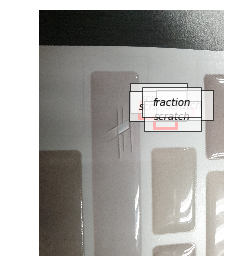

In [9]:
img, bbox, label = train_dataset[0]
ax = vis_bbox(img, bbox, label, label_names=bccd_labels)
ax.set_axis_off()
ax.figure.tight_layout()
plt.show()

In [10]:
# SSD300 (Single Shot Multibox Detector 300 epoch) training
class MultiboxTrainChain(chainer.Chain):

    def __init__(self, model, alpha=1, k=3):
        super(MultiboxTrainChain, self).__init__()
        with self.init_scope():
            self.model = model
        self.alpha = alpha
        self.k = k

    def forward(self, imgs, gt_mb_locs, gt_mb_labels):
        mb_locs, mb_confs = self.model(imgs)
        loc_loss, conf_loss = multibox_loss(
            mb_locs, mb_confs, gt_mb_locs, gt_mb_labels, self.k)
        loss = loc_loss * self.alpha + conf_loss

        chainer.reporter.report(
            {'loss': loss, 'loss/loc': loc_loss, 'loss/conf': conf_loss},
            self)

        return loss

In [11]:
model = SSD300(n_fg_class=len(bccd_labels), pretrained_model='imagenet')
train_chain = MultiboxTrainChain(model)

In [12]:
# Data Augmentation
class Transform(object):

    def __init__(self, coder, size, mean):
        # to send cpu, make a copy
        self.coder = copy.copy(coder)
        self.coder.to_cpu()

        self.size = size
        self.mean = mean

    def __call__(self, in_data):
        # There are five data augmentation steps
        # 1. Color augmentation
        # 2. Random expansion
        # 3. Random cropping
        # 4. Resizing with random interpolation
        # 5. Random horizontal flipping

        img, bbox, label = in_data

        # 1. Color augmentation
        img = random_distort(img)

        # 2. Random expansion
        if np.random.randint(2):
            img, param = transforms.random_expand(
                img, fill=self.mean, return_param=True)
            bbox = transforms.translate_bbox(
                bbox, y_offset=param['y_offset'], x_offset=param['x_offset'])

        # 3. Random cropping
        img, param = random_crop_with_bbox_constraints(
            img, bbox, return_param=True)
        bbox, param = transforms.crop_bbox(
            bbox, y_slice=param['y_slice'], x_slice=param['x_slice'],
            allow_outside_center=False, return_param=True)
        label = label[param['index']]

        # 4. Resizing with random interpolatation
        _, H, W = img.shape
        img = resize_with_random_interpolation(img, (self.size, self.size))
        bbox = transforms.resize_bbox(bbox, (H, W), (self.size, self.size))

        # 5. Random horizontal flipping
        img, params = transforms.random_flip(
            img, x_random=True, return_param=True)
        bbox = transforms.flip_bbox(
            bbox, (self.size, self.size), x_flip=params['x_flip'])

        # Preparation for SSD network
        img -= self.mean
        mb_loc, mb_label = self.coder.encode(bbox, label)

        return img, mb_loc, mb_label

In [13]:
chainer.backends.cuda.set_max_workspace_size(4096 * 4096 * 4096)

chainer.config.autotune = True

In [14]:
batchsize = 32
gpu_id = 0
out = 'results'
initial_lr = 0.001
training_epoch = 300
log_interval = 10, 'epoch'
lr_decay_rate = 0.1
lr_decay_timing = [200, 250]

In [15]:
transformed_train_dataset = TransformDataset(train_dataset, 
                        Transform(model.coder, model.insize, model.mean))

train_iter = chainer.iterators.MultiprocessIterator(transformed_train_dataset, 
                                                batchsize)
valid_iter = chainer.iterators.SerialIterator(valid_dataset, batchsize, 
                                            repeat=False, shuffle=False)

optimizer = chainer.optimizers.MomentumSGD()

In [16]:
optimizer.setup(train_chain)
for param in train_chain.params():
    if param.name == 'b':
    # if param.name == 't':
        param.update_rule.add_hook(GradientScaling(2))
    else:
        param.update_rule.add_hook(WeightDecay(0.0005))

In [17]:
updater = training.updaters.StandardUpdater(
    train_iter, optimizer, device=gpu_id)

In [37]:
trainer = training.Trainer(
    updater,
    (training_epoch, 'epoch'), out)

trainer.extend(
    extensions.ExponentialShift('lr', lr_decay_rate, init=initial_lr),
    trigger=triggers.ManualScheduleTrigger(lr_decay_timing, 'epoch'))

trainer.extend(
    DetectionVOCEvaluator(
        valid_iter, model, use_07_metric=False,
        label_names=bccd_labels),
    trigger=(1, 'epoch'))

trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(extensions.observe_lr(), trigger=log_interval)
trainer.extend(extensions.PrintReport(
    ['epoch', 'iteration', 'lr',
     'main/loss', 'main/loss/loc', 'main/loss/conf',
     'validation/main/map', 'elapsed_time']),
    trigger=log_interval)
if extensions.PlotReport.available():
    trainer.extend(
        extensions.PlotReport(
            ['main/loss', 'main/loss/loc', 'main/loss/conf'],
            'epoch', file_name='loss.png'))
    trainer.extend(
        extensions.PlotReport(
            ['validation/main/map'],
            'epoch', file_name='accuracy.png'))
trainer.extend(extensions.snapshot(
    filename='snapshot_epoch_{.updater.epoch}.npz'), trigger=(10, 'epoch'))

In [56]:
# trainer.run()

In [52]:
# !wget https://github.com/japan-medical-ai/medical-ai-course-materials/releases/download/v0.1/detection_snapshot_epoch_290.npz

# ValueError: could not broadcast input array from shape (205) into shape (36)
# BCCD train: 205개 -> tile train: 36개 이므로 shape error 발생!!!!!!!!!!!!!!!!!!!!!!!!!

chainer.serializers.load_npz('detection_snapshot_epoch_290.npz',trainer)

ValueError: could not broadcast input array from shape (205) into shape (36)